In [4]:
!pip install -q flwr["simulation"] tensorflow


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import flwr as fl
from keras.models import load_model, Sequential
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report
import keras
from keras.layers import Dense, LSTM
import seaborn as sns
from google.colab import drive
from functools import partial
from tensorflow.keras.models import Model


In [8]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/data/Prepared/ciciot2023-reduced.csv')

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/data/Prepared/cic-iot-2023-updated.csv')

In [ ]:
np.any(np.isnan(data))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


False

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
data.drop(columns='Unnamed: 0', inplace=True)
data

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,TCP,UDP,ARP,ICMP,IPv,LLC,Tot sum,Tot size,IAT,label
0,0.058119,45775.0,17.00,64.00,15751.092885,15751.092885,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,525.00,50.00,8.310224e+07,1
1,0.163528,307054.5,16.66,62.72,5495.021216,5495.021216,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,5747.84,544.12,8.378485e+07,1
2,0.035925,57.9,6.00,64.00,1.053108,1.053108,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,567.80,54.20,8.307590e+07,1
3,0.057972,32777.0,17.00,64.00,11023.574801,11023.574801,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,525.00,50.00,8.310633e+07,1
4,35.910337,27837.3,6.00,115.80,69.272535,69.272535,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,5926.50,1063.20,2.455997e-03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1177093,77.484036,853.3,8.80,83.70,13.152179,13.152179,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1983.60,156.60,1.665172e+08,0
1177094,15.082374,1390970.4,6.00,198.40,86.491632,86.491632,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,797.40,355.60,2.140188e-03,0
1177095,30.180086,35568.6,7.10,132.00,8.743544,8.743544,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,526.80,95.70,2.274399e-02,0
1177096,31.893272,597766.1,8.20,80.60,32.563963,32.563963,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,3340.50,685.90,5.189991e-03,0


In [ ]:
## Shuffle the dataset before the split
from sklearn.utils import shuffle

data = shuffle(data).reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
### Dividing the dataset into train, val and test set
# X = data.drop('label', axis=1)
# y = data['label']

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [ ]:
X_, X_test,y_, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

scalar = StandardScaler()
scalar.fit(X_test)
X_scaled = scalar.fit_transform(X_)
X_test_scaled = scalar.transform(X_test)

In [ ]:
X_test.shape

(58855, 33)

In [ ]:
VERBOSE = 0
NUM_CLIENTS = 7
partition_size = X_scaled.shape[0] // NUM_CLIENTS
client_id_to_indices = {}
beg_ids = [i * partition_size for i in range(NUM_CLIENTS)]
end_ids = [i * partition_size for i in range(1, NUM_CLIENTS + 1)]
for client_id, (beg_id, end_id) in enumerate(zip(beg_ids, end_ids)):
    client_id_to_indices[client_id] = [beg_id, end_id]

x_split = np.array_split(X_scaled, NUM_CLIENTS)
y_split = np.array_split(y_, NUM_CLIENTS)
num_data_in_split = x_split[0].shape[0]
train_split = 0.999
val_split = 0.0005


X_trains, y_trains, X_vals, y_vals, X_tests, y_tests = {}, {}, {}, {}, {}, {}
for idx, (client_x, client_y) in enumerate(zip(x_split, y_split)):
    train_end_idx = int(train_split * num_data_in_split)
    val_end_idx = int((train_split + val_split) * num_data_in_split)

    X_trains[str(idx)] = client_x[:train_end_idx]
    y_trains[str(idx)] = client_y[:train_end_idx]

    X_vals[str(idx)] = client_x[train_end_idx:val_end_idx]
    y_vals[str(idx)] = client_y[train_end_idx:val_end_idx]

    X_tests[str(idx)] = client_x[val_end_idx:]
    y_tests[str(idx)] = client_y[val_end_idx:]

In [ ]:
# Reshape the data for LSTM
for idx in range(NUM_CLIENTS):
    X_trains[str(idx)] = X_trains[str(idx)].reshape((X_trains[str(idx)].shape[0], X_trains[str(idx)].shape[1], 1))
    X_vals[str(idx)] = X_vals[str(idx)].reshape((X_vals[str(idx)].shape[0], X_vals[str(idx)].shape[1], 1))
    X_tests[str(idx)] = X_tests[str(idx)].reshape((X_tests[str(idx)].shape[0], X_tests[str(idx)].shape[1], 1))

In [ ]:
print(X_tests['0'].shape)
print(X_vals['0'].shape)
print(X_trains['0'].shape)

(80, 33)
(80, 33)
(159589, 33)


In [ ]:
print(f"Partition size: {partition_size}")
print(beg_ids)
end_ids

Partition size: 159749
[0, 159749, 319498, 479247, 638996, 798745, 958494]


[159749, 319498, 479247, 638996, 798745, 958494, 1118243]

In [ ]:

def get_ann():
  model = Sequential()
  model.add(tf.keras.layers.Input(shape=(33,)),)
  model.add(Dense(4, activation='relu'),)
  model.add(Dense(4, activation='relu'),)
  model.add(Dense(1, activation='sigmoid'),)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=['accuracy'])
  return model

def get_lstm():
    model = Sequential()
    model.add(tf.keras.layers.Input(shape=(33,1)))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=['accuracy'])
    return model

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, X_train, y_train, X_val, y_val,X_test, y_test):
        self.model = get_ann()
        # self.model.build(self, input_shape=(None, 43))
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.X_train, self.y_train, validation_data=(self.X_val, self.y_val), epochs=2, batch_size=512, verbose=VERBOSE)
        return self.model.get_weights(), len(self.X_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, accuracy = self.model.evaluate(self.X_test, self.y_test)
        # Generate predictions
        y_pred = self.model.predict(self.X_test,verbose=VERBOSE)
        y_pred = (y_pred > 0.5)

        # Compute classification report
        class_report = classification_report(self.y_test, y_pred, digits=5)

        return loss, len(self.X_test), {"loss": loss, "accuracy": accuracy, "classification_report": class_report}


In [ ]:
## Defining the client function
def create_client(cid, X_trains, y_trains, X_vals, y_vals, X_tests, y_tests) -> fl.client.Client:
    """Create a Flower client representing a single organization."""
    model = get_ann()  # Pass model_class as an argument

    return FlowerClient(model, X_trains[cid], y_trains[cid], X_vals[cid], y_vals[cid], X_tests[cid], y_tests[cid]).to_client()


client_fnc = partial(
    create_client,
    # model_class=ANN,
    X_trains=X_trains,
    y_trains=y_trains,
    X_vals=X_vals,
    y_vals=y_vals,
    X_tests = X_tests,
    y_tests = y_tests,
)

In [ ]:
def weighted_average(metrics):
    total_samples = sum(num_samples for num_samples, _ in metrics)
    agg_loss = sum(num_samples * m.get("loss",0) for num_samples, m in metrics) / total_samples
    agg_accuracy = sum(num_samples * m.get("accuracy",1) for num_samples, m in metrics) / total_samples

    # Collect classification reports
    classification_reports = [m.get("classification_report", "") for _, m in metrics]

    # Print each classification report with client number
    # for i, report in enumerate(classification_reports):
    #     print(f"Classification report for client {i+1}:\n{report}\n")

    return {"agg_loss": agg_loss, "agg_accuracy": agg_accuracy}

from typing import Dict, List, Tuple

def get_evaluate_fn(X_test, y_test):
    """Return an evaluation function for server-side (i.e. centralised) evaluation."""

    # The `evaluate` function will be called after every round by the strategy
    def evaluate(
        server_round: int,
        parameters: fl.common.NDArrays,
        config: Dict[str, fl.common.Scalar],
    ):
        model = get_ann()  # Construct the model
        # model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
        model.set_weights(parameters)  # Update model with the latest parameters
        loss, accuracy = model.evaluate(X_test, y_test, verbose=VERBOSE)
        y_pred = model.predict(X_test)
        y_pred = (y_pred > 0.5)
        class_report = classification_report(y_test, y_pred, digits=5)

        return loss, {"loss":loss, "accuracy": accuracy, "Centralised report": class_report}

    return evaluate

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=1.0,  # Sample 100% of available clients for evaluation
    min_fit_clients=NUM_CLIENTS,  # Never sample less than 2 clients for training
    min_evaluate_clients=NUM_CLIENTS,  # Never sample less than 5 clients for evaluation
    min_available_clients=NUM_CLIENTS,  # Wait until all 5 clients are available
    evaluate_metrics_aggregation_fn=weighted_average, # aggregates federated metrics
    evaluate_fn=get_evaluate_fn(X_test_scaled, y_test),## global evaluation function
)



In [ ]:
# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fnc,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=40),
    strategy=strategy,
    client_resources={"num_cpus": 1, "num_gpus": 0},
    ray_init_args={
        "num_cpus": 1,
        "num_gpus": 0,
        "_system_config": {"automatic_object_spilling_enabled": False},
    },
)


INFO :      Starting Flower simulation, config: num_rounds=40, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-06-12 17:01:30,907	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'memory': 8012459214.0, 'object_store_memory': 4006229606.0, 'CPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=38662) 2024-06-12 17:01:41.733391: E external/local

1840/1840 [==============================] - 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
INFO :      initial parameters (loss, other metrics): 1.00947773

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (1, 0.28239497542381287, {'loss': 0.28239497542381287, 'accuracy': 0.9585591554641724, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.96713   0.96164   0.96438     34330\n           1    0.94672   0.95425   0.95047     24525\n\n    accuracy                        0.95856     58855\n   macro avg    0.95693   0.95794   0.95742     58855\nweighted avg    0.95863   0.95856   0.95858     58855\n'}, 19.107750069999383)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.2810 - accuracy: 0.9412


(ClientAppActor pid=38662) WARNING:tensorflow:5 out of the last 10 calls to <function Model.make_test_function.<locals>.test_function at 0x7da5dfece950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


6/6 [==============================] - 0s 2ms/step - loss: 0.3476 - accuracy: 0.9412


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.2456 - accuracy: 0.9516


INFO :      aggregate_fit: received 3 results and 0 failures
(ClientAppActor pid=38662) WARNING:tensorflow:5 out of the last 15 calls to <function Model.make_test_function.<locals>.test_function at 0x7da5dffee290> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (2, 0.1602853238582611, {'loss': 0.1602853238582611, 'accuracy': 0.9801886081695557, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.96797   0.99910   0.98329     34330\n           1    0.99868   0.95372   0.97568     24525\n\n    accuracy                        0.98019     58855\n   macro avg    0.98332   0.97641   0.97948     58855\nweighted avg    0.98076   0.98019   0.98012     58855\n'}, 41.734787272000176)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.2227 - accuracy: 0.9626


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.1232 - accuracy: 0.9892


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 4s 2ms/step


INFO :      fit progress: (3, 0.11249025911092758, {'loss': 0.11249025911092758, 'accuracy': 0.9820235967636108, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97079   0.99924   0.98481     34330\n           1    0.99889   0.95792   0.97798     24525\n\n    accuracy                        0.98202     58855\n   macro avg    0.98484   0.97858   0.98140     58855\nweighted avg    0.98250   0.98202   0.98197     58855\n'}, 66.72608154199952)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.1123 - accuracy: 0.9840


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 3ms/step - loss: 0.1691 - accuracy: 0.9679


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 3s 2ms/step


INFO :      fit progress: (4, 0.08781784772872925, {'loss': 0.08781784772872925, 'accuracy': 0.9834678173065186, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97354   0.99881   0.98601     34330\n           1    0.99827   0.96200   0.97980     24525\n\n    accuracy                        0.98347     58855\n   macro avg    0.98590   0.98040   0.98290     58855\nweighted avg    0.98384   0.98347   0.98342     58855\n'}, 89.95481411500077)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0513 - accuracy: 0.9946


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.1449 - accuracy: 0.9679


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (5, 0.07496819645166397, {'loss': 0.07496819645166397, 'accuracy': 0.9838926196098328, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97436   0.99866   0.98636     34330\n           1    0.99806   0.96322   0.98033     24525\n\n    accuracy                        0.98389     58855\n   macro avg    0.98621   0.98094   0.98335     58855\nweighted avg    0.98424   0.98389   0.98385     58855\n'}, 112.81806462200075)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0413 - accuracy: 0.9946


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0764 - accuracy: 0.9840


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (6, 0.06750407814979553, {'loss': 0.06750407814979553, 'accuracy': 0.9845892190933228, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97550   0.99866   0.98694     34330\n           1    0.99806   0.96489   0.98120     24525\n\n    accuracy                        0.98459     58855\n   macro avg    0.98678   0.98178   0.98407     58855\nweighted avg    0.98490   0.98459   0.98455     58855\n'}, 134.97371252899939)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0368 - accuracy: 0.9946


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.1239 - accuracy: 0.9679


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (7, 0.06344477832317352, {'loss': 0.06344477832317352, 'accuracy': 0.9847591519355774, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97578   0.99866   0.98709     34330\n           1    0.99806   0.96530   0.98141     24525\n\n    accuracy                        0.98476     58855\n   macro avg    0.98692   0.98198   0.98425     58855\nweighted avg    0.98506   0.98476   0.98472     58855\n'}, 158.01864844699958)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.1230 - accuracy: 0.9679


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0615 - accuracy: 0.9893


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (8, 0.06115920841693878, {'loss': 0.06115920841693878, 'accuracy': 0.984963059425354, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97622   0.99854   0.98726     34330\n           1    0.99789   0.96595   0.98166     24525\n\n    accuracy                        0.98496     58855\n   macro avg    0.98706   0.98225   0.98446     58855\nweighted avg    0.98525   0.98496   0.98493     58855\n'}, 179.72334822099947)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0349 - accuracy: 0.9946


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.1223 - accuracy: 0.9679


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (9, 0.05992868170142174, {'loss': 0.05992868170142174, 'accuracy': 0.9851159453392029, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97644   0.99857   0.98738     34330\n           1    0.99794   0.96628   0.98185     24525\n\n    accuracy                        0.98512     58855\n   macro avg    0.98719   0.98243   0.98462     58855\nweighted avg    0.98540   0.98512   0.98508     58855\n'}, 201.40298289699967)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 3ms/step - loss: 0.0570 - accuracy: 0.9893


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0347 - accuracy: 0.9946


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (10, 0.05874280631542206, {'loss': 0.05874280631542206, 'accuracy': 0.9851329326629639, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97674   0.99828   0.98740     34330\n           1    0.99752   0.96673   0.98188     24525\n\n    accuracy                        0.98513     58855\n   macro avg    0.98713   0.98250   0.98464     58855\nweighted avg    0.98540   0.98513   0.98510     58855\n'}, 222.6713151240001)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.9946


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 3ms/step - loss: 0.1180 - accuracy: 0.9679


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 4s 2ms/step


INFO :      fit progress: (11, 0.05788762494921684, {'loss': 0.05788762494921684, 'accuracy': 0.9853538274765015, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97702   0.99837   0.98758     34330\n           1    0.99764   0.96714   0.98215     24525\n\n    accuracy                        0.98535     58855\n   macro avg    0.98733   0.98275   0.98487     58855\nweighted avg    0.98562   0.98535   0.98532     58855\n'}, 244.13525609299904)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.1202 - accuracy: 0.9626


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0538 - accuracy: 0.9893


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (12, 0.05743413046002388, {'loss': 0.05743413046002388, 'accuracy': 0.9854387640953064, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97689   0.99866   0.98766     34330\n           1    0.99806   0.96693   0.98225     24525\n\n    accuracy                        0.98544     58855\n   macro avg    0.98748   0.98280   0.98495     58855\nweighted avg    0.98571   0.98544   0.98540     58855\n'}, 267.30964715499977)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0527 - accuracy: 0.9893


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.1189 - accuracy: 0.9679


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (13, 0.05705439671874046, {'loss': 0.05705439671874046, 'accuracy': 0.9854387640953064, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97676   0.99881   0.98766     34330\n           1    0.99827   0.96673   0.98225     24525\n\n    accuracy                        0.98544     58855\n   macro avg    0.98751   0.98277   0.98495     58855\nweighted avg    0.98572   0.98544   0.98540     58855\n'}, 289.76714277300016)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0387 - accuracy: 0.9946


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0507 - accuracy: 0.9893


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (14, 0.0562751479446888, {'loss': 0.0562751479446888, 'accuracy': 0.9855577349662781, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97717   0.99857   0.98775     34330\n           1    0.99794   0.96734   0.98240     24525\n\n    accuracy                        0.98556     58855\n   macro avg    0.98755   0.98296   0.98508     58855\nweighted avg    0.98582   0.98556   0.98552     58855\n'}, 311.5530057699998)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0513 - accuracy: 0.9893


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0377 - accuracy: 0.9946


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (15, 0.05608613044023514, {'loss': 0.05608613044023514, 'accuracy': 0.9855407476425171, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97706   0.99866   0.98774     34330\n           1    0.99806   0.96718   0.98238     24525\n\n    accuracy                        0.98554     58855\n   macro avg    0.98756   0.98292   0.98506     58855\nweighted avg    0.98581   0.98554   0.98551     58855\n'}, 334.0775590129997)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 4ms/step - loss: 0.0507 - accuracy: 0.9893


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0378 - accuracy: 0.9946


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (16, 0.056010179221630096, {'loss': 0.056010179221630096, 'accuracy': 0.985608696937561, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97720   0.99863   0.98780     34330\n           1    0.99802   0.96738   0.98246     24525\n\n    accuracy                        0.98561     58855\n   macro avg    0.98761   0.98301   0.98513     58855\nweighted avg    0.98588   0.98561   0.98557     58855\n'}, 358.31084410400035)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0511 - accuracy: 0.9893


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.1166 - accuracy: 0.9679


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 3s 1ms/step


INFO :      fit progress: (17, 0.055822938680648804, {'loss': 0.055822938680648804, 'accuracy': 0.985642671585083, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97720   0.99869   0.98783     34330\n           1    0.99811   0.96738   0.98250     24525\n\n    accuracy                        0.98564     58855\n   macro avg    0.98765   0.98303   0.98517     58855\nweighted avg    0.98591   0.98564   0.98561     58855\n'}, 381.2637507670006)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0391 - accuracy: 0.9946


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.1181 - accuracy: 0.9679


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (18, 0.055726032704114914, {'loss': 0.055726032704114914, 'accuracy': 0.9857276082038879, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97709   0.99895   0.98790     34330\n           1    0.99848   0.96722   0.98260     24525\n\n    accuracy                        0.98573     58855\n   macro avg    0.98779   0.98308   0.98525     58855\nweighted avg    0.98601   0.98573   0.98569     58855\n'}, 403.91389223499937)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.1159 - accuracy: 0.9679


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0383 - accuracy: 0.9946


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 3s 1ms/step


INFO :      fit progress: (19, 0.05544517561793327, {'loss': 0.05544517561793327, 'accuracy': 0.9857786297798157, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97745   0.99866   0.98794     34330\n           1    0.99807   0.96775   0.98267     24525\n\n    accuracy                        0.98578     58855\n   macro avg    0.98776   0.98320   0.98531     58855\nweighted avg    0.98604   0.98578   0.98575     58855\n'}, 427.21058597199954)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.1147 - accuracy: 0.9679


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0394 - accuracy: 0.9946


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (20, 0.055254723876714706, {'loss': 0.055254723876714706, 'accuracy': 0.985659658908844, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97742   0.99849   0.98784     34330\n           1    0.99781   0.96771   0.98253     24525\n\n    accuracy                        0.98566     58855\n   macro avg    0.98762   0.98310   0.98518     58855\nweighted avg    0.98592   0.98566   0.98563     58855\n'}, 449.5604118219999)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0395 - accuracy: 0.9946


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0512 - accuracy: 0.9893


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 3s 1ms/step


INFO :      fit progress: (21, 0.05512424185872078, {'loss': 0.05512424185872078, 'accuracy': 0.9857786297798157, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97750   0.99860   0.98794     34330\n           1    0.99798   0.96783   0.98267     24525\n\n    accuracy                        0.98578     58855\n   macro avg    0.98774   0.98322   0.98531     58855\nweighted avg    0.98604   0.98578   0.98575     58855\n'}, 470.11684402100036)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 3ms/step - loss: 0.0393 - accuracy: 0.9946


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 4ms/step - loss: 0.0511 - accuracy: 0.9893


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 3s 1ms/step


INFO :      fit progress: (22, 0.05507297441363335, {'loss': 0.05507297441363335, 'accuracy': 0.9857786297798157, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97745   0.99866   0.98794     34330\n           1    0.99807   0.96775   0.98267     24525\n\n    accuracy                        0.98578     58855\n   macro avg    0.98776   0.98320   0.98531     58855\nweighted avg    0.98604   0.98578   0.98575     58855\n'}, 494.16939220600034)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0408 - accuracy: 0.9946


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.1153 - accuracy: 0.9679


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 3s 1ms/step


INFO :      fit progress: (23, 0.055048033595085144, {'loss': 0.055048033595085144, 'accuracy': 0.9857956171035767, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97756   0.99857   0.98795     34330\n           1    0.99794   0.96791   0.98270     24525\n\n    accuracy                        0.98580     58855\n   macro avg    0.98775   0.98324   0.98532     58855\nweighted avg    0.98605   0.98580   0.98576     58855\n'}, 514.2598395080004)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.1148 - accuracy: 0.9679


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 3ms/step - loss: 0.0505 - accuracy: 0.9893


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 3s 2ms/step


INFO :      fit progress: (24, 0.055024947971105576, {'loss': 0.055024947971105576, 'accuracy': 0.9858805537223816, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97767   0.99860   0.98803     34330\n           1    0.99798   0.96807   0.98280     24525\n\n    accuracy                        0.98588     58855\n   macro avg    0.98783   0.98334   0.98541     58855\nweighted avg    0.98613   0.98588   0.98585     58855\n'}, 534.9963542610003)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.1175 - accuracy: 0.9679


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0390 - accuracy: 0.9946


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (25, 0.055042069405317307, {'loss': 0.055042069405317307, 'accuracy': 0.9857616424560547, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97747   0.99860   0.98793     34330\n           1    0.99798   0.96779   0.98265     24525\n\n    accuracy                        0.98576     58855\n   macro avg    0.98773   0.98319   0.98529     58855\nweighted avg    0.98602   0.98576   0.98573     58855\n'}, 559.1706373790003)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.1168 - accuracy: 0.9679


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0496 - accuracy: 0.9893


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 3s 1ms/step


INFO :      fit progress: (26, 0.054994236677885056, {'loss': 0.054994236677885056, 'accuracy': 0.985642671585083, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97733   0.99854   0.98783     34330\n           1    0.99790   0.96758   0.98251     24525\n\n    accuracy                        0.98564     58855\n   macro avg    0.98762   0.98306   0.98517     58855\nweighted avg    0.98590   0.98564   0.98561     58855\n'}, 580.0784337810001)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 3ms/step - loss: 0.0415 - accuracy: 0.9946


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 3ms/step - loss: 0.1170 - accuracy: 0.9679


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (27, 0.05488412827253342, {'loss': 0.05488412827253342, 'accuracy': 0.9857956171035767, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97759   0.99854   0.98795     34330\n           1    0.99790   0.96795   0.98270     24525\n\n    accuracy                        0.98580     58855\n   macro avg    0.98774   0.98325   0.98532     58855\nweighted avg    0.98605   0.98580   0.98576     58855\n'}, 604.052456116)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0413 - accuracy: 0.9946


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.1177 - accuracy: 0.9679


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 3s 1ms/step


INFO :      fit progress: (28, 0.05452680215239525, {'loss': 0.05452680215239525, 'accuracy': 0.9858126044273376, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97791   0.99822   0.98796     34330\n           1    0.99744   0.96844   0.98273     24525\n\n    accuracy                        0.98581     58855\n   macro avg    0.98768   0.98333   0.98534     58855\nweighted avg    0.98605   0.98581   0.98578     58855\n'}, 627.1610906269998)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.1170 - accuracy: 0.9679


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0403 - accuracy: 0.9946


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (29, 0.05452711507678032, {'loss': 0.05452711507678032, 'accuracy': 0.9858465790748596, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97767   0.99854   0.98800     34330\n           1    0.99790   0.96807   0.98276     24525\n\n    accuracy                        0.98585     58855\n   macro avg    0.98778   0.98331   0.98538     58855\nweighted avg    0.98610   0.98585   0.98581     58855\n'}, 651.7038506289991)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0515 - accuracy: 0.9893


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0418 - accuracy: 0.9946


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 3s 1ms/step


INFO :      fit progress: (30, 0.05479472875595093, {'loss': 0.05479472875595093, 'accuracy': 0.9858126044273376, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97759   0.99857   0.98797     34330\n           1    0.99794   0.96795   0.98272     24525\n\n    accuracy                        0.98581     58855\n   macro avg    0.98776   0.98326   0.98534     58855\nweighted avg    0.98607   0.98581   0.98578     58855\n'}, 673.6159440840001)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 4ms/step - loss: 0.0406 - accuracy: 0.9946


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0519 - accuracy: 0.9893


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 3s 1ms/step


INFO :      fit progress: (31, 0.05442289635539055, {'loss': 0.05442289635539055, 'accuracy': 0.9858126044273376, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97789   0.99825   0.98796     34330\n           1    0.99748   0.96840   0.98272     24525\n\n    accuracy                        0.98581     58855\n   macro avg    0.98768   0.98333   0.98534     58855\nweighted avg    0.98605   0.98581   0.98578     58855\n'}, 697.6547953070003)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 4ms/step - loss: 0.0419 - accuracy: 0.9946


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 3s 2ms/step


INFO :      fit progress: (32, 0.054582659155130386, {'loss': 0.054582659155130386, 'accuracy': 0.9858975410461426, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97770   0.99860   0.98804     34330\n           1    0.99798   0.96811   0.98282     24525\n\n    accuracy                        0.98590     58855\n   macro avg    0.98784   0.98336   0.98543     58855\nweighted avg    0.98615   0.98590   0.98587     58855\n'}, 721.247954429)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0435 - accuracy: 0.9892


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0518 - accuracy: 0.9893


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 3s 1ms/step


INFO :      fit progress: (33, 0.05467170849442482, {'loss': 0.05467170849442482, 'accuracy': 0.9860504865646362, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97787   0.99869   0.98817     34330\n           1    0.99811   0.96836   0.98301     24525\n\n    accuracy                        0.98605     58855\n   macro avg    0.98799   0.98352   0.98559     58855\nweighted avg    0.98630   0.98605   0.98602     58855\n'}, 743.6488817530008)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0416 - accuracy: 0.9946


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0515 - accuracy: 0.9893


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (34, 0.05427686497569084, {'loss': 0.05427686497569084, 'accuracy': 0.9859485030174255, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97792   0.99846   0.98808     34330\n           1    0.99777   0.96844   0.98289     24525\n\n    accuracy                        0.98595     58855\n   macro avg    0.98785   0.98345   0.98548     58855\nweighted avg    0.98619   0.98595   0.98592     58855\n'}, 763.331818654)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 3ms/step - loss: 0.1183 - accuracy: 0.9679


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 3ms/step - loss: 0.0427 - accuracy: 0.9946


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (35, 0.05416329950094223, {'loss': 0.05416329950094223, 'accuracy': 0.9859654903411865, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97808   0.99831   0.98809     34330\n           1    0.99756   0.96869   0.98291     24525\n\n    accuracy                        0.98597     58855\n   macro avg    0.98782   0.98350   0.98550     58855\nweighted avg    0.98620   0.98597   0.98593     58855\n'}, 789.5762652939993)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.1172 - accuracy: 0.9679


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0516 - accuracy: 0.9893


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (36, 0.05435182899236679, {'loss': 0.05435182899236679, 'accuracy': 0.9859485030174255, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97797   0.99840   0.98808     34330\n           1    0.99769   0.96852   0.98289     24525\n\n    accuracy                        0.98595     58855\n   macro avg    0.98783   0.98346   0.98548     58855\nweighted avg    0.98619   0.98595   0.98592     58855\n'}, 810.2376713129997)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 3ms/step - loss: 0.0505 - accuracy: 0.9893


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 3ms/step - loss: 0.0443 - accuracy: 0.9892


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 4s 2ms/step


INFO :      fit progress: (37, 0.05436662584543228, {'loss': 0.05436662584543228, 'accuracy': 0.9860674738883972, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97779   0.99881   0.98818     34330\n           1    0.99828   0.96824   0.98303     24525\n\n    accuracy                        0.98607     58855\n   macro avg    0.98803   0.98352   0.98561     58855\nweighted avg    0.98632   0.98607   0.98604     58855\n'}, 831.7299119060008)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0440 - accuracy: 0.9892


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0495 - accuracy: 0.9893


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (38, 0.05414094030857086, {'loss': 0.05414094030857086, 'accuracy': 0.9859485030174255, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97803   0.99834   0.98808     34330\n           1    0.99761   0.96860   0.98289     24525\n\n    accuracy                        0.98595     58855\n   macro avg    0.98782   0.98347   0.98548     58855\nweighted avg    0.98619   0.98595   0.98592     58855\n'}, 853.5727294429998)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0439 - accuracy: 0.9892


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0502 - accuracy: 0.9893


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 3s 2ms/step


INFO :      fit progress: (39, 0.05405743047595024, {'loss': 0.05405743047595024, 'accuracy': 0.9861184358596802, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97814   0.99851   0.98822     34330\n           1    0.99786   0.96877   0.98310     24525\n\n    accuracy                        0.98612     58855\n   macro avg    0.98800   0.98364   0.98566     58855\nweighted avg    0.98636   0.98612   0.98609     58855\n'}, 876.7280664720001)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.1176 - accuracy: 0.9679


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0450 - accuracy: 0.9892


INFO :      aggregate_fit: received 3 results and 0 failures


1840/1840 [==============================] - 3s 2ms/step


INFO :      fit progress: (40, 0.05420570820569992, {'loss': 0.05420570820569992, 'accuracy': 0.9860164523124695, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97787   0.99863   0.98814     34330\n           1    0.99802   0.96836   0.98297     24525\n\n    accuracy                        0.98602     58855\n   macro avg    0.98795   0.98349   0.98555     58855\nweighted avg    0.98627   0.98602   0.98598     58855\n'}, 898.9848741379992)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


6/6 [==============================] - 0s 2ms/step - loss: 0.0493 - accuracy: 0.9893


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 40 round(s) in 902.18s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.29146120894168104
INFO :      		round 2: 0.16434684422399318
INFO :      		round 3: 0.11847468085054841
INFO :      		round 4: 0.09597138520330191
INFO :      		round 5: 0.08336572341088738
INFO :      		round 6: 0.07620272221309798
INFO :      		round 7: 0.0737505577770727
INFO :      		round 8: 0.07191020846366883
INFO :      		round 9: 0.07159229293465615
INFO :      		round 10: 0.06959641855875297
INFO :      		round 11: 0.07033163206651807
INFO :      		round 12: 0.06972002003874098
INFO :      		round 13: 0.06844676272012293
INFO :      		round 14: 0.06756123499279576
INFO :      		round 15: 0.06828229559718497
INFO :      		round 16: 0.0686983134664063
INFO :      		round 17: 0.0693653341449265
INFO :      		round 18: 0.06849702212161252
INFO :      		round 19: 0.068

6/6 [==============================] - 0s 2ms/step - loss: 0.0436 - accuracy: 0.9892


INFO :      		round 18: 0.055726032704114914
INFO :      		round 19: 0.05544517561793327
INFO :      		round 20: 0.055254723876714706
INFO :      		round 21: 0.05512424185872078
INFO :      		round 22: 0.05507297441363335
INFO :      		round 23: 0.055048033595085144
INFO :      		round 24: 0.055024947971105576
INFO :      		round 25: 0.055042069405317307
INFO :      		round 26: 0.054994236677885056
INFO :      		round 27: 0.05488412827253342
INFO :      		round 28: 0.05452680215239525
INFO :      		round 29: 0.05452711507678032
INFO :      		round 30: 0.05479472875595093
INFO :      		round 31: 0.05442289635539055
INFO :      		round 32: 0.054582659155130386
INFO :      		round 33: 0.05467170849442482
INFO :      		round 34: 0.05427686497569084
INFO :      		round 35: 0.05416329950094223
INFO :      		round 36: 0.05435182899236679
INFO :      		round 37: 0.05436662584543228
INFO :      		round 38: 0.05414094030857086
INFO :      		round 39: 0.05405743047595024
INFO :      		round 40: 0

In [ ]:
"""
The function below takes the accuracy and loss both of type list as an argument and
plot them on two separate graphs.
"""
def figures(acc_values, loss_values):
  plt.plot(acc_values)
  plt.legend(['Accuracy'], loc = 'lower right')
  plt.ylabel('Accuracy')
  plt.xlabel('Rounds')
  plt.title(f"Accuracy curve: Federated learning with {NUM_CLIENTS} clients")
  plt.show()
  plt.plot(loss_values)
  plt.legend(['loss'], loc = 'upper right')
  plt.ylabel('Test loss')
  plt.xlabel('Rounds')
  plt.title(f"Loss curve: Federated learning with {NUM_CLIENTS} clients")
  plt.show()

## Metrics for 3 clients

In [ ]:
var = history.metrics_centralized['Centralised report']
print(type(var))
for i in var:
  for pair in i:
    print(pair)

<class 'list'>
0
              precision    recall  f1-score   support

           0    0.74692   0.56796   0.64526     34254
           1    0.54892   0.73204   0.62739     24601

    accuracy                        0.63655     58855
   macro avg    0.64792   0.65000   0.63633     58855
weighted avg    0.66416   0.63655   0.63779     58855

1
              precision    recall  f1-score   support

           0    0.96678   0.95311   0.95990     34254
           1    0.93598   0.95439   0.94510     24601

    accuracy                        0.95365     58855
   macro avg    0.95138   0.95375   0.95250     58855
weighted avg    0.95390   0.95365   0.95371     58855

2
              precision    recall  f1-score   support

           0    0.96960   0.98234   0.97593     34254
           1    0.97495   0.95712   0.96595     24601

    accuracy                        0.97180     58855
   macro avg    0.97227   0.96973   0.97094     58855
weighted avg    0.97184   0.97180   0.97176     58855

In [ ]:
accuracy = history.metrics_centralized['accuracy']
acc_values = [item[1] for item in accuracy]
loss = history.metrics_centralized['loss']
loss_values = [item[1] for item in loss]

print(loss_values)
acc_values

[0.6365838646888733, 0.15108737349510193, 0.10373906046152115, 0.09046149253845215, 0.08417840301990509, 0.08028397709131241, 0.07762164622545242, 0.07583383470773697, 0.07446080446243286, 0.07328861206769943, 0.07198689132928848, 0.07116056978702545, 0.07022611796855927, 0.0696226954460144, 0.06886858493089676, 0.06822428107261658, 0.06738255172967911, 0.06521783024072647, 0.06343388557434082, 0.0618412122130394, 0.06053810566663742, 0.058022137731313705, 0.056935347616672516, 0.05631042644381523, 0.056054387241601944, 0.05583414435386658, 0.05554665997624397, 0.055463001132011414, 0.055223092436790466, 0.05503597483038902, 0.05496540293097496, 0.054946355521678925, 0.054838698357343674, 0.05450648441910744, 0.054520513862371445, 0.05329955741763115, 0.05289355292916298, 0.05264441296458244, 0.052550993859767914, 0.05244418606162071, 0.05237371474504471]


[0.6365474462509155,
 0.9536488056182861,
 0.9717950820922852,
 0.9760937690734863,
 0.9777418971061707,
 0.9787613749504089,
 0.979984700679779,
 0.9802735447883606,
 0.9803075194358826,
 0.9808512330055237,
 0.9812420606613159,
 0.9813609719276428,
 0.981819748878479,
 0.9817687273025513,
 0.9819896221160889,
 0.9822954535484314,
 0.9823464155197144,
 0.983195960521698,
 0.9835528135299683,
 0.9841305017471313,
 0.9841474890708923,
 0.9845382571220398,
 0.9845212697982788,
 0.9848101139068604,
 0.984929084777832,
 0.984963059425354,
 0.9850649833679199,
 0.9851499199867249,
 0.9850649833679199,
 0.9851159453392029,
 0.9851499199867249,
 0.9851159453392029,
 0.9850989580154419,
 0.9851669073104858,
 0.9850819706916809,
 0.9852009415626526,
 0.9853198528289795,
 0.9852858781814575,
 0.9852349162101746,
 0.9852179288864136,
 0.9853028655052185]

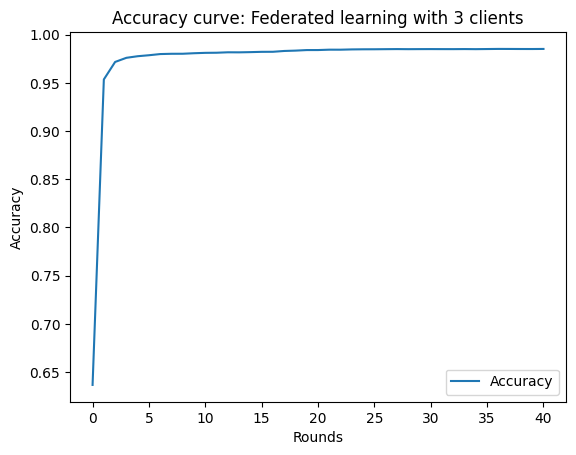

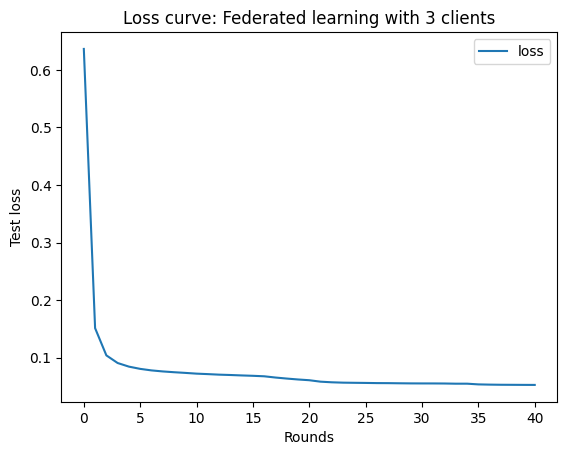

In [ ]:
figures(acc_values, loss_values)

In [ ]:
var = history.metrics_centralized['Centralised report']
print(type(var))
for i in var:
  for pair in i:
    print(pair)

<class 'list'>
0
              precision    recall  f1-score   support

           0    0.50535   0.62053   0.55705     34387
           1    0.21538   0.14640   0.17431     24468

    accuracy                        0.42341     58855
   macro avg    0.36037   0.38346   0.36568     58855
weighted avg    0.38480   0.42341   0.39793     58855

1
              precision    recall  f1-score   support

           0    0.96245   0.93320   0.94760     34387
           1    0.90997   0.94883   0.92899     24468

    accuracy                        0.93970     58855
   macro avg    0.93621   0.94102   0.93830     58855
weighted avg    0.94063   0.93970   0.93986     58855

2
              precision    recall  f1-score   support

           0    0.97082   0.98398   0.97735     34387
           1    0.97704   0.95844   0.96765     24468

    accuracy                        0.97336     58855
   macro avg    0.97393   0.97121   0.97250     58855
weighted avg    0.97341   0.97336   0.97332     58855

In [ ]:
accuracy = history.metrics_centralized['accuracy']
acc_values = [item[1] for item in accuracy]
loss = history.metrics_centralized['loss']
loss_values = [item[1] for item in loss]

loss_values
acc_values

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0.42341348528862,
 0.9396992325782776,
 0.9733582735061646,
 0.9784895181655884,
 0.9804264903068542,
 0.9815139174461365]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


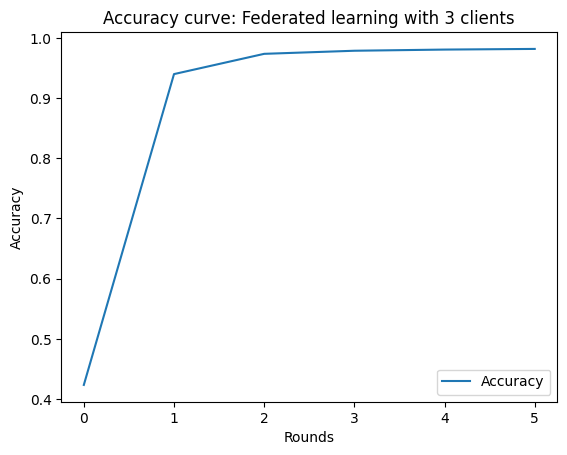

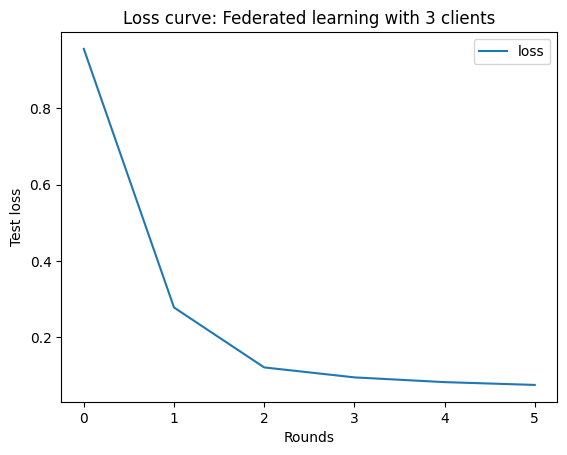

In [ ]:
figures(acc_values, loss_values)

## Metrics for 5 clients

In [ ]:
var = history.metrics_centralized['Centralised report']
print(type(var))
for i in var:
  for pair in i:
    print(pair)

<class 'list'>
0
              precision    recall  f1-score   support

           0    0.58129   1.00000   0.73521     34212
           1    0.00000   0.00000   0.00000     24643

    accuracy                        0.58129     58855
   macro avg    0.29065   0.50000   0.36761     58855
weighted avg    0.33790   0.58129   0.42737     58855

1
              precision    recall  f1-score   support

           0    0.97022   0.93420   0.95187     34212
           1    0.91313   0.96019   0.93607     24643

    accuracy                        0.94509     58855
   macro avg    0.94168   0.94720   0.94397     58855
weighted avg    0.94632   0.94509   0.94526     58855

2
              precision    recall  f1-score   support

           0    0.97013   0.98246   0.97626     34212
           1    0.97521   0.95800   0.96653     24643

    accuracy                        0.97222     58855
   macro avg    0.97267   0.97023   0.97139     58855
weighted avg    0.97226   0.97222   0.97218     58855

In [ ]:
accuracy = history.metrics_centralized['accuracy']
acc_values = [item[1] for item in accuracy]
loss = history.metrics_centralized['loss']
loss_values = [item[1] for item in loss]

print(loss_values)
print(acc_values)

[0.7623205184936523, 0.25958052277565, 0.14536574482917786, 0.0979616641998291, 0.07905885577201843, 0.06715220212936401, 0.060834478586912155, 0.058030128479003906, 0.05610992759466171, 0.054843030869960785, 0.054103557020425797, 0.053267259150743484, 0.05246446281671524, 0.05250844359397888, 0.05190197005867958, 0.05133935436606407, 0.051015738397836685, 0.05076779052615166, 0.050790946930646896, 0.05003596842288971, 0.05011806637048721, 0.04958442226052284, 0.04976021870970726, 0.04946711286902428, 0.04943172261118889, 0.0489894337952137, 0.049074046313762665, 0.049001485109329224, 0.04909561946988106, 0.04910442233085632, 0.04867161437869072, 0.0485689602792263, 0.04851581156253815, 0.0485769622027874, 0.04853515699505806, 0.04843592643737793, 0.04849685728549957, 0.04838826134800911, 0.04867292940616608, 0.048231031745672226, 0.04832765460014343]
[0.581292986869812, 0.9450854063034058, 0.9722198843955994, 0.9778608679771423, 0.9805793762207031, 0.9829921126365662, 0.98457223176956

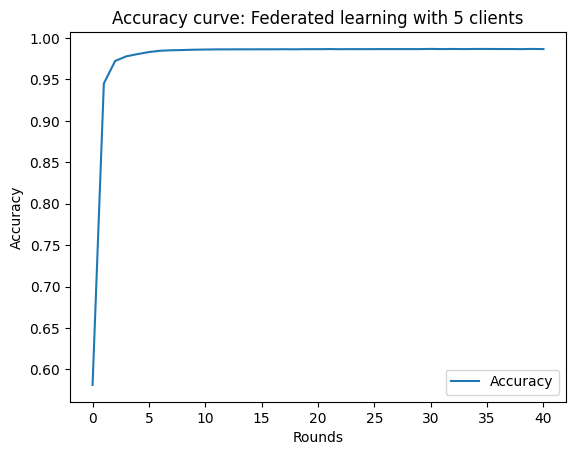

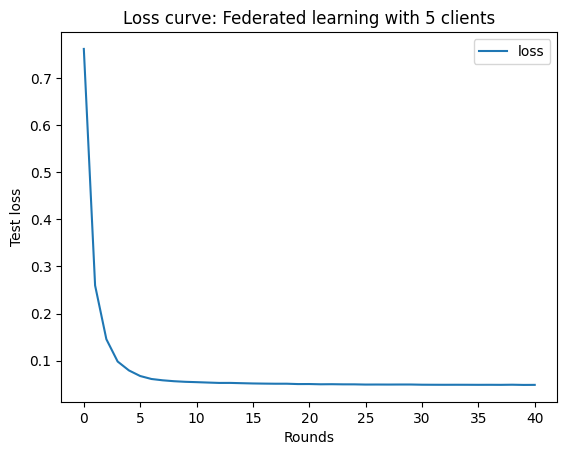

In [ ]:
figures(acc_values, loss_values)

In [ ]:
var = history.metrics_centralized['Centralised report']
print(type(var))
for i in var:
  for pair in i:
    print(pair)

<class 'list'>
0
              precision    recall  f1-score   support

           0    0.71190   0.82473   0.76417     34387
           1    0.68309   0.53094   0.59748     24468

    accuracy                        0.70259     58855
   macro avg    0.69750   0.67783   0.68083     58855
weighted avg    0.69992   0.70259   0.69487     58855

1
              precision    recall  f1-score   support

           0    0.97073   0.98671   0.97866     34387
           1    0.98088   0.95819   0.96940     24468

    accuracy                        0.97485     58855
   macro avg    0.97581   0.97245   0.97403     58855
weighted avg    0.97495   0.97485   0.97481     58855

2
              precision    recall  f1-score   support

           0    0.97320   0.99160   0.98231     34387
           1    0.98787   0.96162   0.97457     24468

    accuracy                        0.97914     58855
   macro avg    0.98053   0.97661   0.97844     58855
weighted avg    0.97930   0.97914   0.97909     58855

In [ ]:
accuracy = history.metrics_centralized['accuracy']
acc_values = [item[1] for item in accuracy]
loss = history.metrics_centralized['loss']
loss_values = [item[1] for item in loss]

loss_values
acc_values

[0.7025911211967468,
 0.9748534560203552,
 0.9791351556777954,
 0.9821085929870605,
 0.9840795397758484,
 0.9854217767715454]

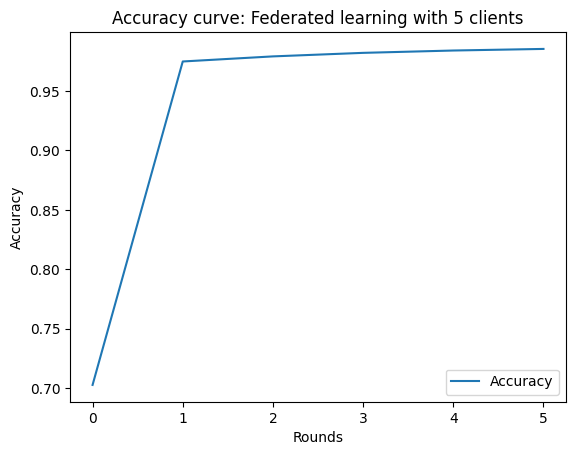

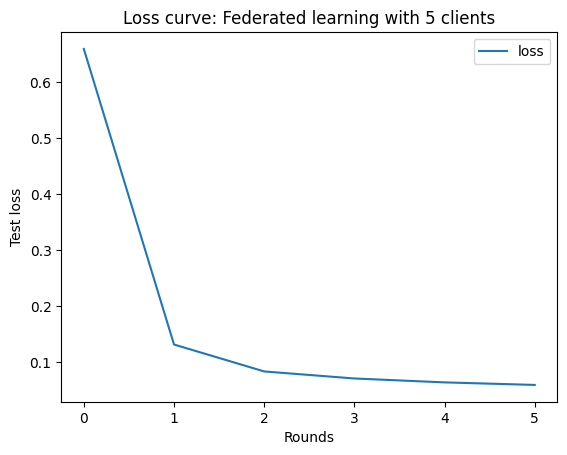

In [ ]:
figures(acc_values, loss_values)

## Metrics for 7 client

In [ ]:
var = history.metrics_centralized['Centralised report']
print(type(var))
for i in var:
  for pair in i:
    print(pair)

<class 'list'>
0
              precision    recall  f1-score   support

           0    0.24167   0.21373   0.22684     34212
           1    0.05941   0.06894   0.06382     24643

    accuracy                        0.15311     58855
   macro avg    0.15054   0.14134   0.14533     58855
weighted avg    0.16536   0.15311   0.15858     58855

1
              precision    recall  f1-score   support

           0    0.96696   0.93672   0.95160     34212
           1    0.91580   0.95557   0.93526     24643

    accuracy                        0.94461     58855
   macro avg    0.94138   0.94614   0.94343     58855
weighted avg    0.94554   0.94461   0.94476     58855

2
              precision    recall  f1-score   support

           0    0.97382   0.99597   0.98477     34212
           1    0.99422   0.96283   0.97827     24643

    accuracy                        0.98209     58855
   macro avg    0.98402   0.97940   0.98152     58855
weighted avg    0.98236   0.98209   0.98205     58855

In [ ]:
accuracy = history.metrics_centralized['accuracy']
acc_values = [item[1] for item in accuracy]
loss = history.metrics_centralized['loss']
loss_values = [item[1] for item in loss]

print(loss_values)
print(acc_values)

[1.037072777748108, 0.13631121814250946, 0.06605252623558044, 0.06234158203005791, 0.055325351655483246, 0.05300336703658104, 0.0524522140622139, 0.050909705460071564, 0.05065321922302246, 0.05023820698261261, 0.05002092570066452, 0.05020654574036598, 0.05045352503657341, 0.05001514032483101, 0.050018541514873505, 0.05005275085568428, 0.05018652603030205, 0.049688808619976044, 0.049712348729372025, 0.04969299957156181, 0.04978349804878235, 0.049685925245285034, 0.049533065408468246, 0.04968411847949028, 0.04995300620794296, 0.04971965029835701, 0.04943939670920372, 0.049489304423332214, 0.04942623898386955, 0.049349889159202576, 0.04950732737779617, 0.049402859061956406, 0.04919859394431114, 0.04936062544584274, 0.04898668825626373, 0.049045950174331665, 0.04914242401719093, 0.04921278730034828, 0.04912913218140602, 0.04883131384849548, 0.04863554611802101]
[0.15310509502887726, 0.9446096420288086, 0.9820916056632996, 0.9822784662246704, 0.984946072101593, 0.9855067729949951, 0.9856766

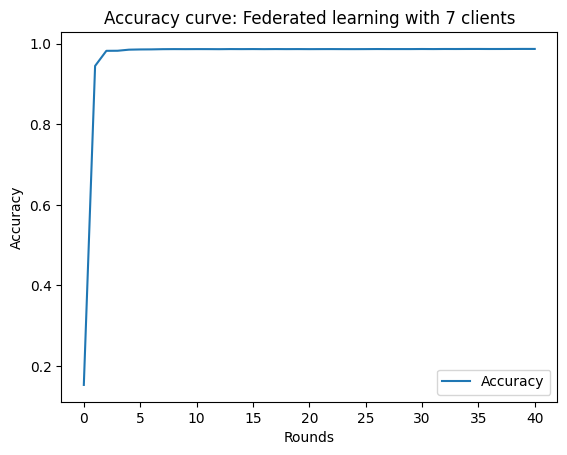

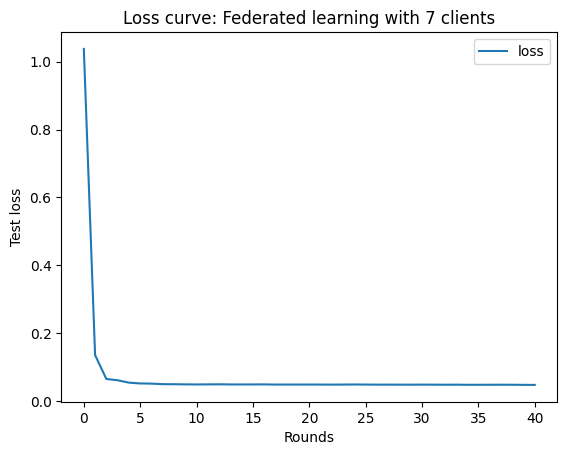

In [ ]:
figures(acc_values, loss_values)

In [ ]:

var = history.metrics_centralized['Centralised report']
print(type(var))
for i in var:
  for pair in i:
    print(pair)

<class 'list'>
0
              precision    recall  f1-score   support

           0    0.58344   0.99642   0.73595     34387
           1    0.03150   0.00016   0.00033     24468

    accuracy                        0.58224     58855
   macro avg    0.30747   0.49829   0.36814     58855
weighted avg    0.35398   0.58224   0.43013     58855

1
              precision    recall  f1-score   support

           0    0.97618   0.99747   0.98671     34387
           1    0.99633   0.96579   0.98082     24468

    accuracy                        0.98430     58855
   macro avg    0.98626   0.98163   0.98377     58855
weighted avg    0.98456   0.98430   0.98426     58855

2
              precision    recall  f1-score   support

           0    0.97820   0.99715   0.98759     34387
           1    0.99588   0.96878   0.98214     24468

    accuracy                        0.98535     58855
   macro avg    0.98704   0.98296   0.98486     58855
weighted avg    0.98555   0.98535   0.98532     58855

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
accuracy = history.metrics_centralized['accuracy']
acc_values = [item[1] for item in accuracy]
loss = history.metrics_centralized['loss']
loss_values = [item[1] for item in loss]

loss_values
acc_values

[0.4529946446418762,
 0.9698241353034973,
 0.977537989616394,
 0.9795939326286316,
 0.980035662651062,
 0.9804944396018982]

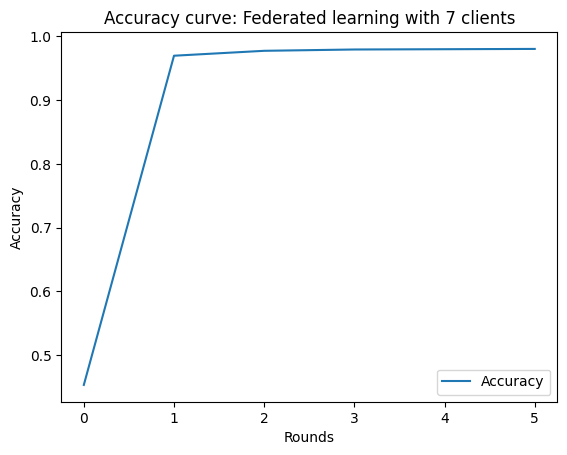

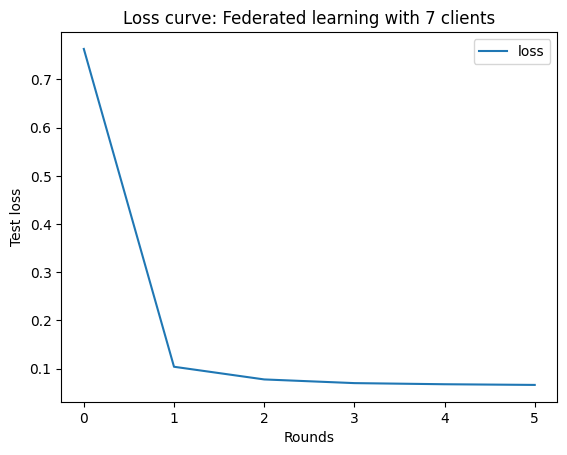

In [ ]:
figures(acc_values, loss_values)

## Visualizing the results